Data description:
> mock: mocked dataset with a small subset of images & labels \
> wangtest: original paper test set \
> wangtrain: original paper train set \
> train1 (split into a,b,c): ['H', 'X', 'L', 'Y'] \
> test 1: ['G'] \
> train2 (split into a,b,c): ['H', 'G', 'L', 'Y'] \
> test2: ['X'] \
> train3 (split into a,b,c): ['H', 'X', 'G'] \
> test3: ['L', 'Y']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_paths = {
    "train1": "/content/drive/Shareddrives/DL_Final_Project/shuffle/train1",
    "test1": "/content/drive/Shareddrives/DL_Final_Project/FINAL_DATASETS/test1",
    "train2": "/content/drive/Shareddrives/DL_Final_Project/shuffle/train2",
    "test2": "/content/drive/Shareddrives/DL_Final_Project/FINAL_DATASETS/test2",
    "train3": "/content/drive/Shareddrives/DL_Final_Project/shuffle/train3",
    "test3": "/content/drive/Shareddrives/DL_Final_Project/FINAL_DATASETS/test3",
    "train4": "/content/drive/Shareddrives/DL_Final_Project/FINAL_DATASETS/train4",
    "test4": "/content/drive/Shareddrives/DL_Final_Project/FINAL_DATASETS/test4"
}

In [ ]:
directory_dict = {
    "group1" :  "/content/drive/Shareddrives/DL_Final_Project/checkpoints1",
    "group2" :  "/content/drive/Shareddrives/DL_Final_Project/checkpoints2",
    "group3" :  "/content/drive/Shareddrives/DL_Final_Project/checkpoints3",
    "group4" :  "/content/drive/Shareddrives/DL_Final_Project/checkpoints4"
}

In [ ]:
# contains num_classes for each dataset -- test & train are the same
num_classes_dict = {
    "train1": 1777,
    "train2": 1656,
    "train3": 1628,
    "train4": 1588
}

In [ ]:
'''
Returns the args for the group
num_classes, train_data, test_data, directory
'''
def get_group_args(group):
  assert group in [1,2,3,4]
  if group==1:
    num_classes = num_classes_dict["train1"]
    train_data = dataset_paths["train1"]
    test_data = dataset_paths["test1"]
    directory = directory_dict["group1"]
  if group==2:
    num_classes = num_classes_dict["train2"]
    train_data = dataset_paths["train2"]
    test_data = dataset_paths["test2"]
    directory = directory_dict["group2"]
  if group == 3:
    num_classes = num_classes_dict["train3"]
    train_data = dataset_paths["train3"]
    test_data = dataset_paths["test3"]
    directory = directory_dict["group3"]
  if group == 4:
    num_classes = num_classes_dict["train4"]
    train_data = dataset_paths["train4"]
    test_data = dataset_paths["test4"]
    directory = directory_dict["group4"]
  return num_classes, train_data, test_data, directory


In [ ]:
num_classes, train_datapath, test_datapath, directory = get_group_args(3)
directory = directory + "_visualization"
                                                # CHANGE THIS NUMBER ONLY WHEN SWITCHING GROUPS

In [ ]:
import tensorflow as tf
# ======================= LOAD DATASETS =======================
# load train set
train_dataset = tf.data.Dataset.load(train_datapath)
                                      # change train1 to other keys in dataset_paths

# load test set
test_dataset = tf.data.Dataset.load(test_datapath)
                                      # change test1 to other keys

# # uncomment to see shapes:
# for item in train_dataset.take(5):
#   print(item[0].shape)
#   print(item[1].shape)

# ^^ MICHELLE ADDED THE ABOVE LINES 5/2; DID NOT CHANGE BELOW
# ============================================================
# batching
batch_size = 5
train_dataset1 = train_dataset.batch(batch_size)
train_dataset1 = train_dataset1.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset=test_dataset.batch(batch_size)
test_dataset1 = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(len(train_dataset1))
#print(num_classes)
print(len(test_dataset1))
#print(num_classes_test)


13152
2062


# Residual

The functionality of a residual block typically found in ResNet architectures. It includes convolutional layers, batch normalization, and possible adjustments in dimensions through 1x1 convolutions and stride alterations.

In [ ]:
from tqdm import tqdm
import os
import math
import json
import pandas as pd
import argparse
import random
import numpy as np
import sys
from datetime import datetime

In [ ]:
# Create a parser
parser = argparse.ArgumentParser(description='Train on HUST-OBS')

# Add expected arguments
parser.add_argument('--lr', '--learning-rate', default=0.001, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=50, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--batch_size', default=256.0, type=float, metavar='N', help='mini-batch size')
parser.add_argument('--num_workers', default=24.0, type=float)
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')
#change --resume to change trained model to visualize results from
parser.add_argument('--resume', default='/content/drive/Shareddrives/DL_Final_Project/checkpoints3', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--checkpoint_freq', type=int, default=5)
parser.add_argument('--seed', type=int, default=42)

# Check if the code is running in the IPython environment
if 'ipykernel' in sys.modules:
    # Assume a default setup; modify as needed or determine a way to set these via the notebook interface
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

# Set random seed for reproducibility
tf.random.set_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)

if not os.path.exists(directory):
    os.makedirs(directory)

print(args)

In [ ]:
class Residual(tf.keras.layers.Layer):
    def __init__(self, input_channels, min_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(min_channels, kernel_size=1)
                                           # input_shape=(None, None, input_channels))
        self.conv2 = tf.keras.layers.Conv2D(min_channels, kernel_size=3, padding='valid', strides=strides)
        self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1)

        if use_1x1conv:
            self.conv4 = tf.keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv4 = None

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=None):
        X = inputs
        Y = tf.nn.relu(self.bn1(self.conv1(X), training=training))
        paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
        Y = tf.pad(Y, paddings)
        Y = self.bn2(self.conv2(Y), training=training)
        Y = self.bn3(self.conv3(Y), training=training)

        if self.conv4:
            X = self.conv4(X)

        return tf.nn.relu(Y + X)

# InitialBlock

This constructs the very first layers of the network which are crucial for reducing spatial dimensions and increasing depth (number of channels) before entering the main residual blocks.

In [ ]:
# Initial block with convolution, batch norm, ReLU, and max pooling
class InitialBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(InitialBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='valid')
        #valid padding with additional pads before to be equiv to nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='valid')
        #valid padding with additional pads before to be equiv to nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def call(self, inputs, training=None):
        paddings = tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]])
        inputs = tf.pad(inputs, paddings)
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        pool_paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
        x = tf.pad(x, pool_paddings)
        x = self.pool(x)
        return x

# ResNet Block Function
This function uses the Residual class to construct sequences of residual blocks, which are the core components of ResNet architectures. It organizes these blocks based on their position in the network, adjusting their properties for downsampling or maintaining dimensionality where necessary.

In [ ]:
def resnet_block(input_channels, min_channels, num_channels, num_residuals, stride,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, min_channels, num_channels,
                                use_1x1conv=True, strides=stride))
        elif i == 0 and first_block:
            blk.append(Residual(input_channels, min_channels, num_channels, use_1x1conv=True))
        else:
            blk.append(Residual(num_channels, min_channels, num_channels))
    return blk

# MyResNet50

This class integrates all previously defined components into a complete network. It uses the InitialBlock to process the input initially, then sequentially passes the data through multiple resnet_block sequences to form the deep architecture typical of ResNets. It concludes with global average pooling and a fully connected layer to produce the final output.

In [ ]:
class MyResNet50(tf.keras.Model):
    def __init__(self):
        super(MyResNet50, self).__init__()
        self.b1 = InitialBlock()
        self.b2 = tf.keras.Sequential(resnet_block(64, 64, 256, 3, 2, first_block=True))
        self.b3 = tf.keras.Sequential(resnet_block(256, 128, 512, 4, 2))
        self.b4 = tf.keras.Sequential(resnet_block(512, 256, 1024, 6, 2))
        self.b5 = tf.keras.Sequential(resnet_block(1024, 512, 2048, 2, 2))

        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes) #needs to be changed based on the train set's num classes

    def call(self, inputs, training=None):
        x = self.b1(inputs, training=training)
        x = self.b2(x, training=training)
        x = self.b3(x, training=training)
        x = self.b4(x, training=training)
        x = self.b5(x, training=training)
        x = self.avg_pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x

# Weight Initialization

In [ ]:
# Weight Initialization
model = MyResNet50()
model.build((batch_size, 128, 128, 3))  # Assuming input images are 128x128 with 3 channels
model.summary()
initializer = tf.keras.initializers.GlorotUniform()
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_initializer = initializer

Model: "my_res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 initial_block (InitialBloc  multiple                  9728      
 k)                                                              
                                                                 
 sequential (Sequential)     (5, 32, 32, 256)          219008    
                                                                 
 sequential_1 (Sequential)   (5, 16, 16, 512)          1228288   
                                                                 
 sequential_2 (Sequential)   (5, 8, 8, 1024)           7124992   
                                                                 
 sequential_3 (Sequential)   (5, 4, 4, 2048)           10518528  
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                              

# Accuracy

In [ ]:
def accuracy(y_pred, y_true):
    predicted_indices = tf.argmax(y_pred, axis=1)
    true_indices = tf.argmax(y_true, axis=1)  # Assuming y_true is one-hot encoded
    correct_predictions = tf.equal(predicted_indices, true_indices)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Load model

In [ ]:
# Load model and optimizer states if resuming from a checkpoint
assert(args.resume)
checkpoint = tf.train.Checkpoint(model, optimizer=optimizer)
status = checkpoint.restore(tf.train.latest_checkpoint(args.resume))
status.assert_existing_objects_matched()
print(f'Loaded from: {args.resume}')

# Ensure the results directory exists
if not os.path.exists(directory):
    os.makedirs(directory)

Loaded from: /content/drive/Shareddrives/DL_Final_Project/checkpoints3


# Testing On Picture

In [ ]:
def visualize(model, dataset):
  count = 0
  printed = 0
  for batch_image, batch_label in dataset:
    if count % 150 == 0: #change numbers to get images from different parts of the dataset
      printed += 1
      predictions = model(batch_image, training=False)
      predictions = tf.keras.layers.Softmax()(predictions)
      predictions = predictions * 100 #turn into percentages
      values, indices = tf.math.top_k(predictions, 5)
      true_labels = tf.math.argmax(batch_label, axis=1).numpy()
      split_vals = tf.split(values, 5)
      split_indices = tf.split(indices, 5)
      for image, vals, indices, true in zip(batch_image, split_vals, split_indices, true_labels):
        vals = np.round(vals.numpy(), 3)
        indices = indices.numpy()
        display(tf.keras.utils.array_to_img(image))
        print(vals)
        print(indices)
        print(true)
    if printed == 5: #change to print more images
      break
    count += 1

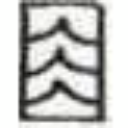

[[100.   0.   0.   0.   0.]]
[[   0  317  816 1559  253]]
0


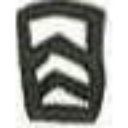

[[56.088 14.408 13.677  9.294  2.603]]
[[   0  299  939 1093  493]]
0


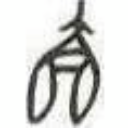

[[9.9911e+01 7.5000e-02 1.0000e-02 3.0000e-03 1.0000e-03]]
[[   1  378 1287  329 1043]]
1


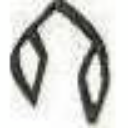

[[47.757 38.205  6.64   3.164  1.765]]
[[ 486 1062 1012  348  282]]
1


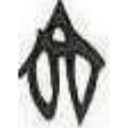

[[87.663  6.056  1.819  1.455  0.99 ]]
[[   1 1074 1287  329  578]]
1


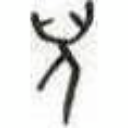

[[9.8468e+01 1.4880e+00 2.2000e-02 2.1000e-02 0.0000e+00]]
[[ 169  161   74 1291  398]]
169


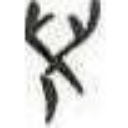

[[9.8959e+01 9.7400e-01 4.8000e-02 1.3000e-02 4.0000e-03]]
[[ 169 1291 1099 1177  937]]
169


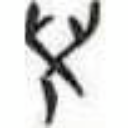

[[9.92e+01 7.97e-01 1.00e-03 1.00e-03 0.00e+00]]
[[ 169 1291  161 1177  937]]
169


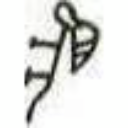

[[70.963 10.093  9.896  4.836  2.546]]
[[ 171  578 1100  118 1287]]
170


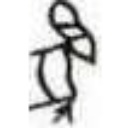

[[46.211 18.362 17.238  5.524  3.431]]
[[ 717 1315 1413  171 1473]]
170


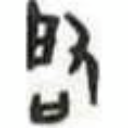

[[89.418  4.908  3.859  1.037  0.293]]
[[ 332  725  891  506 1297]]
332


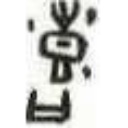

[[9.9994e+01 3.0000e-03 3.0000e-03 0.0000e+00 0.0000e+00]]
[[ 334  377 1251 1311  787]]
334


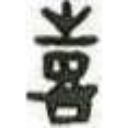

[[73.923 11.597  7.064  6.837  0.311]]
[[ 377 1311  334  787 1251]]
334


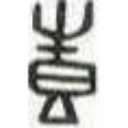

[[100.   0.   0.   0.   0.]]
[[ 377  334 1046 1311 1529]]
334


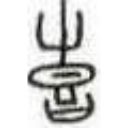

[[9.9286e+01 6.8700e-01 2.3000e-02 3.0000e-03 0.0000e+00]]
[[ 334 1046  377  952  316]]
334


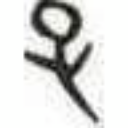

[[9.997e+01 1.600e-02 7.000e-03 3.000e-03 1.000e-03]]
[[ 467 1254  562 1161  266]]
467


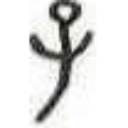

[[9.7545e+01 1.7360e+00 4.9900e-01 6.6000e-02 2.6000e-02]]
[[ 562  467   86  934 1549]]
467


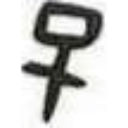

[[9.6078e+01 3.8530e+00 1.5000e-02 1.5000e-02 1.1000e-02]]
[[ 467  562  299 1271 1105]]
467


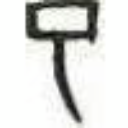

[[80.569 14.164  1.488  1.197  1.08 ]]
[[562 709 654 731 843]]
467


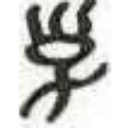

[[9.9312e+01 2.5200e-01 1.7700e-01 7.3000e-02 3.2000e-02]]
[[ 467 1184  480  886  292]]
467


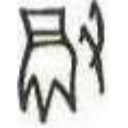

[[9.6898e+01 3.0850e+00 1.5000e-02 1.0000e-03 0.0000e+00]]
[[ 635  506 1412 1256  217]]
635


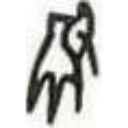

[[30.621 21.277 20.364  8.722  5.784]]
[[1412 1075  625  897 1099]]
635


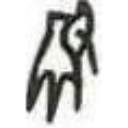

[[40.434 35.224 10.373  6.415  2.221]]
[[1410 1412  625 1075  897]]
635


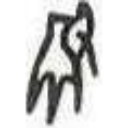

[[55.755 11.873  5.806  5.541  5.111]]
[[ 625 1412 1187  897 1410]]
635


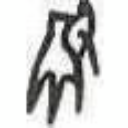

[[54.536 24.189  6.145  4.799  2.4  ]]
[[ 625 1412 1410  506 1075]]
635


In [ ]:
visualize(model, test_dataset1)